# Long Short Term Memory Based Spectrum Sensing in Cognitive Radio Networks
[Published in IEEE Access-2020 and PIMRC-2019].






---

Copyright reserved by: Nikhil Balwani, Dhaval K. Patel, Brijesh Soni and Miguel Lopez-Benitez

---







# 1. Importing and Initializing data

The list of packages that will be used in the study: -

1. numpy - For vectorized implementation
2. math - Inbuilt support for mathematical operations
3. time - measuring runtime
4. keras - for LSTM model, training and testing

In [1]:
import numpy as np
import math
from scipy.stats import norm
import time
import pandas as pd
import statsmodels.api as sm
from keras.layers import Dense, Dropout, LSTM, TimeDistributed, Flatten, Bidirectional
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras import layers, models
#import plotly.offline as py
#import plotly.graph_objs as go
#import dill
#py.init_notebook_mode(connected=True)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data for all he four technologies are loaded into their respective vector names. They are all reshaped to convert them from Rank 1 arrays to proper Numpy vectors.

# 2.Retreiving data

Retreiving data from the files for all the four wireless technologies.

In [2]:
# Importing data from file (1840 MHz)
FM = np.fromfile('96_7_20db', dtype=np.float32)

# Reshaping to convert to a proper NUMPY vector
FM = np.reshape(FM, (FM.shape[0], 1))

# Shape of FM signal vector
print("Size of FM: " + str(FM.shape))

Size of FM: (2971649, 1)


# 3. Creating NUMPY equivalent for bandpower function

A MATLAB equivalent for bandpower function is created.

In [3]:
def bandpower(signal):
  return np.mean(signal ** 2)

In [4]:
bandpower(FM)

0.08850595

# 4. Creating NUMPY equivalent for AWGN (Additive White Gaussian Noise) function

First of all, the SNR (Signal-to-noise ratio) is converted from decibel scale to linear scale using the given formula:

$$\text{SNR}_{\text{linear}} = 10 ^ {\frac{\text{SNR}_{\text{dB}}}{10} }$$


The variance of standard the signal is adjusted using the formula given below:

$$\text{SNR}_{\text{linear}} = \frac{Power(signal)}{Var(noise)}\\
\implies \boxed{Power(signal) = Var(noise) \times \text{SNR}_{\text{linear}}}$$

In [5]:
def awgn(signal, desired_snr):
  
  # Converting the SNR from dB scale to linear scale
  snr_linear = math.pow(10, desired_snr / 10)
  
  # Standard normally distributed noise
  noise = np.random.randn(signal.shape[0], 1)
  
  # Using the boxed formula
  var_signal = bandpower(noise) * snr_linear
  
  # Normalizing the signal to have the given variance
  normalized_signal = math.sqrt(var_signal) * (signal / math.sqrt(bandpower(signal)))
  
  print("SNR = " + str(10 * math.log10(bandpower(normalized_signal) / bandpower(noise))))
  
  return normalized_signal + noise

# 5. Filtering the data

The datasets are filtered to remove any transient peaks. Values between $10^{-7}$ and $1$ are retained, others are discarded.

In [6]:


FM = FM[np.logical_and(FM > math.pow(10, -7), FM < 1)]
FM = FM.reshape(FM.shape[0], 1)


 # Shape of FM signal vector
print("Size of FM: " + str(FM.shape))

print(awgn(FM[0:100000], 4).shape)

Size of FM: (2971649, 1)
SNR = 3.999999353326178
(100000, 1)


# 6. Making the dataset ready

The following dataset will create a dataset for the signal with a given SNR, number of samples and size of the samples in the sensing event. Dataset is constructed based on two features: - The test statistic (Zhang Statistic) and Energy of the sensing event.They are defined as below: -

Energy of the sensing event $E$ is given by,

$$E = \sum_{i = 1} ^{N} \big|y[n]\big|^{2} $$

Test statistic $Z_{c}$ is given by, 

$$Z_{c} = \sum_{i = 1}^{N}\Bigg[\log\Bigg\{{\frac{F_{0}(y[i])^{-1} - 1}{\big(N - \frac{1}{2}\big) \big/ \big(i - \frac{3}{4}\big) - 1}}\Bigg\}\Bigg]^{2}$$
 where $F_{0}(y)$ is the known CDF (Cumulative Distrubution Function) of noise.

In [7]:
def create_dataset(signal, desired_snr, samples, sample_size):
  
  # Creating the signal with desired SNR
  snr_signal = awgn(signal[0:samples * sample_size], desired_snr)
  
  # Allocating zeros to the dataset
  X = np.zeros((samples, 2))
  
  # Range of values of i is (0, N)
  j = np.arange(1, sample_size + 1)
  
  for i in range(0, samples):
    
    # Extracting the sample based on sample size
    sampled_signal = snr_signal[i * sample_size : (i + 1) * sample_size]
    
    # Sorting the sampled signal
    sampled_signal = np.sort(sampled_signal, axis=0)
    
    # Energy detection
    E = np.sum(sampled_signal ** 2)
    
    # Computing the Test statistic (Zhang)
    # CDF (Cumulative Distribution Function of Standard Distribution)
    cdf = norm.cdf(sampled_signal)
    cdf = np.sort(cdf, axis=0)
    
    # Computing the numerator
    numerator = (1 / cdf) - 1
    
    # Computing the denominator
    denominator = ( (sample_size - 0.5) / (j - 0.75) ) - 1
    denominator = np.reshape(denominator, (denominator.shape[0], 1))
    
    log = np.log(numerator / denominator)
    
    # Final Zhang statistic computation
    Zc = np.sum(log ** 2)
    
    # Assigning values to the dataset
    X[i][0] = E
    X[i][1] = Zc
    
  # Replacing infinite values with next largest value in the training set for 
  # Zhang statistic
  X[np.isinf(X[:, 1])] = np.max(X[np.logical_not(np.isinf(X[:, 1])), 1])
  
  print("sum = " + str(np.sum(np.isinf(X[:, 1]))))
  
  return X

In [8]:
a = time.time()
print(create_dataset(FM[50000:], 4, 15000, 100).shape)
b = time.time()

# Printing the time taken for execution
print(b - a)

SNR = 4.000000572180325
sum = 0
(15000, 2)
1.8611783981323242


Making the dataset for all the SNRs in the range -20 till 4 with step size of 2. The following function will take a range of SNRs as input and will output the dataset. Other inputs are the sample size, the signal, and, the number of samples per SNR.

In [9]:
def final_dataset(signal, snr_range, samples_per_snr, sample_size):
  X = {}
  
  for snr in snr_range:
    # Creating dataset for the given SNR
    X_snr = create_dataset(signal, snr, samples_per_snr, sample_size)
    
    # Indexing within the final dataset matrix X
    X[snr] = X_snr
  
  return X

# 7. Generating White noise sequence

White noise of variance 1 is generated and is labelled as 0.

In [10]:
def create_noise_sequence(samples, sample_size):
  
  # Creating white noise sequence of variance 1
  noise = np.random.randn(samples * sample_size, 1)
  
  # Allocating zeros to the dataset
  X = np.zeros((samples, 2))
  
  # Range of values of i is (0, N)
  j = np.arange(1, sample_size + 1)
  
  for i in range(0, samples):
    
    # Extracting the sample based on sample size
    sampled_signal = noise[i * sample_size : (i + 1) * sample_size]
    
    # Sorting the sampled signal
    sampled_signal = np.sort(sampled_signal, axis=0)
    
    # Energy detection
    E = np.sum(sampled_signal ** 2)
    
    # Computing the Test statistic (Zhang)
    # CDF (Cumulative Distribution Function of Standard Distribution)
    cdf = norm.cdf(sampled_signal, 0, 1)
    cdf = np.sort(cdf, axis=0)
    
    # Computing the numerator
    numerator = (1 / cdf) - 1
    
    # Computing the denominator
    denominator = ( (sample_size - 0.5) / (j - 0.75) ) - 1
    denominator = np.reshape(denominator, (denominator.shape[0], 1))
    
    log = np.log(numerator / denominator)
    
    # Final Zhang statistic computation
    Zc = np.sum(log ** 2)
    
    # Assigning values to the dataset
    X[i][0] = E
    X[i][1] = Zc
    
  # Replacing infinite values with next largest value in the training set for 
  # Zhang statistic
  X[np.isinf(X[:, 1])] = np.max(X[np.logical_not(np.isinf(X[:, 1])), 1])
  
  print("sum = " + str(np.sum(np.isinf(X[:, 1]))))
  
  return X

In [11]:
a = time.time()
X_noise = create_noise_sequence(100000, 100)
b = time.time()

print("Time taken = " + str(b - a))

print(X_noise.shape)

sum = 0
Time taken = 12.101613521575928
(100000, 2)


# 9. DataSet with Lookback for LSTM

The output of an Recurrent Neural network depends on the previous training examples. Here, we will define a lookback to determine how many previous examples should the RNN look into to predict the output.

In [12]:
# Function for Chaning the dataset for look back
def create_look_back(X, look_back=1):
  
  # Look back dataset is initialized to be empty
  look_back_X = []
  
  for i in range(len(X) - look_back + 1):
    # Extracting an example from the dataset
    a = X[i:(i + look_back), :]
    
    a = a.flatten() # (For flattening)
    
    # Appending to the dataset
    look_back_X.append(a)
  
  look_back_Y = []
    
  # Returning in numpy's array format
  return np.array(look_back_X)

The following function will insert look backs into our dataset for all the SNRs.

In [13]:
def dataset_look_back(X_tech, snr_range, look_back):
  X_tech_lb = {}
  
  for snr in snr_range:
    X_tech_lb[snr] = create_look_back(X_tech[snr], look_back)
  
  return X_tech_lb

In [14]:
look_back = 2

"""

X_FM_lb = dataset_look_back(X_FM, range(-20, 6, 2), look_back)
print(X_FM_lb[-20].shape)

X_noise_lb = create_look_back(X_noise, look_back)
print(X_noise_lb.shape)

X_test_FM_lb  = dataset_look_back(X_FM_test, range(-20, 6, 2), look_back)
"""

'\n\nX_FM_lb = dataset_look_back(X_FM, range(-20, 6, 2), look_back)\nprint(X_FM_lb[-20].shape)\n\nX_noise_lb = create_look_back(X_noise, look_back)\nprint(X_noise_lb.shape)\n\nX_test_FM_lb  = dataset_look_back(X_FM_test, range(-20, 6, 2), look_back)\n'

# 10. Creating the ANN and LSTM models

Defining a sequential model with two stacked LSTM layers with a single Dense output layer.

SNR = -19.99999953768146
sum = 0
SNR = -17.999999556757647
sum = 0
SNR = -15.999999794706296
sum = 0
SNR = -13.999999749308806
sum = 0
SNR = -12.000000015137848
sum = 0
SNR = -9.99999966597813
sum = 0
SNR = -8.00000061702898
sum = 0
SNR = -5.999999931877012
sum = 0
SNR = -4.0000007089980425
sum = 0
SNR = -2.0000014249382807
sum = 0
SNR = -1.707343726528127e-06
sum = 0
SNR = 1.9999978214015555
sum = 0
SNR = 3.9999978183533713
sum = 0
SNR = -19.999998092009385
sum = 0
SNR = -17.99999895106452
sum = 0
SNR = -16.000000394927426
sum = 0
SNR = -13.9999990463152
sum = 0
SNR = -11.999999088992697
sum = 0
SNR = -9.999999012895708
sum = 0
SNR = -7.999999792819547
sum = 0
SNR = -5.999999969156635
sum = 0
SNR = -3.9999994436784543
sum = 0
SNR = -1.9999994543001078
sum = 0
SNR = 4.602301327378396e-07
sum = 0
SNR = 2.0000004573903647
sum = 0
SNR = 4.000000608294114
sum = 0
(99999, 4)
(3399, 4)
(3399, 4)
(197186, 4)
(197186, 1)
Epoch 1/10
1315/1315 - 4s - loss: 0.2933 - accuracy: 0.8773
Epoch 2/10
13

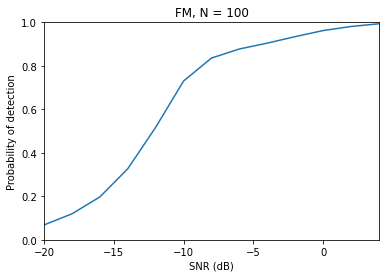

In [15]:
look_back=2
# FM
X_FM = {**final_dataset(FM[200000:], range(-20, -4, 2), 3400, 100), **final_dataset(FM[200000:], range(-4, 6, 2), 14000, 100)}
X_FM_test = {**final_dataset(FM[300000:], range(-20, -4, 2), 3333, 100), **final_dataset(FM[300000:], range(-4, 6, 2), 8000, 100)}

X_noise_lb = create_look_back(X_noise, 2)
print(X_noise_lb.shape)

X_FM_lb = dataset_look_back(X_FM, range(-20, 6, 2), 2)
print(X_FM_lb[-20].shape)

X_test_FM_lb = dataset_look_back(X_FM_test, range(-20, 6, 2), 2)
print(X_FM_lb[-20].shape)

X = X_FM_lb[-20]
y = []

for snr in range(-18, 6, 2):
  X = np.concatenate((X, X_FM_lb[snr]), axis=0)

y = np.ones((X.shape[0], 1))
  
X = np.concatenate((X, X_noise_lb), axis=0)

y = np.concatenate((y, np.zeros((X_noise_lb.shape[0], 1))))

print(X.shape)
print(y.shape)

seed = 9
np.random.seed(seed)
#Loading the data, here It's a feature data, which contains 4 features as mentioned in papers 

#ANN Model 
# create model
model = Sequential() # This means it's sequential model, which is from one direction to another in sequence 
model.add(Dense(7, input_dim=4, kernel_initializer='uniform', activation='relu'))#First layer with 20 nodes and as we have 4 features so input_dim would be 4, relu suits well for binary classification so I have used it
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid')) #Output layer

# Compile model
#This function you have to explore in case you want to do the mathematic analysis
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
#Training and batch size
model.fit(X, y, epochs=10, batch_size=150,  verbose=2)

#Evaluate the model
scores = model.evaluate(X, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

pd1_FM = {}

for snr in range(-20, 6, 2):
  y_snr = np.ones((X_test_FM_lb[snr].shape[0], 1))
  scores = model.evaluate(X_test_FM_lb[snr], y_snr)
  print("At SNR = " + str(snr) + "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  pd1_FM[snr] = scores[1]
  
plt.plot(*zip(*sorted(pd1_FM.items())))
plt.xlabel('SNR (dB)')
plt.ylabel('Probability of detection')
plt.xlim([-20, 4])
plt.ylim([0, 1])

plt.title('FM, N = 100')

scores = model.evaluate(X_noise_lb, np.zeros((X_noise_lb.shape[0], 1)))
print("pfa = "  + str(1 - scores[1]))

In [16]:
a = time.time()

for i in range(0, 1000):
    model.predict(X[0].reshape(1, 4))

b = time.time()

print((b-a)/1000)

0.028857457399368285


# 9. DataSet with Lookback for LSTM

In [17]:
del(create_dataset)

def create_dataset(signal, desired_snr, samples, sample_size):

    # Creating the signal with desired SNR
    snr_signal = awgn(signal[0:(samples + 1) * sample_size], desired_snr)

    # Allocating zeros to the dataset
    X = np.zeros((samples, sample_size * 2))

    
    l = 0
    u = sample_size * 2
        
    for i in range(0, samples):
        
        # Extracting the sample based on sample size
        sampled_signal = snr_signal[l : u]
        
        X[i][0:sample_size * 2] = sampled_signal.T
        
        l = l + sample_size
        u = u + sample_size
    
    return X

In [18]:
a = time.time()
print(create_dataset(FM[50000:], 4, 15000, 100).shape)
b = time.time()

# Printing the time taken for execution
print(b - a)

SNR = 3.999999892825757
(15000, 200)
0.1046140193939209


Making the dataset for all the SNRs in the range -20 till 4 with step size of 2. The following function will take a range of SNRs as input and will output the dataset. Other inputs are the sample size, the signal, and, the number of samples per SNR.

In [19]:
del(final_dataset)

def final_dataset(signal, snr_range, samples_per_snr, sample_size):
  X = {}
  
  for snr in snr_range:
    # Creating dataset for the given SNR
    X_snr = create_dataset(signal, snr, samples_per_snr, sample_size)
    
    # Indexing within the final dataset matrix X
    X[snr] = X_snr
  
  return X

In [20]:
a = time.time()

# FM-1800 band
X_FM = {**final_dataset(FM[200000:], range(-20, -4, 2), 5000, 100), **final_dataset(FM[200000:], range(-4, 6, 2), 12000, 100)}
X_test_FM = {**final_dataset(FM[300000:], range(-20, -4, 2), 3333, 100), **final_dataset(FM[300000:], range(-4, 6, 2), 8000, 100)}
b = time.time()

# Printing the time taken for execution
print("Time taken :- " + str(b - a))

SNR = -19.999999776405886
SNR = -18.00000062328047
SNR = -16.000001469304905
SNR = -14.000000821593376
SNR = -12.000000988834492
SNR = -10.000001189208563
SNR = -8.000000112406957
SNR = -6.00000069382582
SNR = -4.000001429121688
SNR = -2.000001079286569
SNR = -6.180684042209495e-07
SNR = 1.9999996506478712
SNR = 3.999998753817444
SNR = -19.999998469833645
SNR = -17.99999885487874
SNR = -15.999998847257256
SNR = -13.999999681341142
SNR = -11.999999675500721
SNR = -9.999999500066282
SNR = -7.999999907460753
SNR = -5.9999980386008716
SNR = -3.9999979904551997
SNR = -1.9999999846925127
SNR = 1.4704095343987988e-06
SNR = 2.0000007308975887
SNR = 4.000001299982941
Time taken :- 1.0823695659637451


# 7. Generating White noise sequence

White noise of variance 1 is generated and is labelled as 0.

In [21]:
del(create_noise_sequence)

def create_noise_sequence(samples, sample_size):

    # Creating white noise sequence of variance 1
    noise = np.random.randn(samples * (sample_size + 1), 1)

    # Allocating zeros to the dataset
    X = np.zeros((samples, sample_size * 2))

    l = 0
    u = sample_size * 2
    
    for i in range(0, samples):

        # Extracting the sample based on sample size
        sampled_signal = noise[l : u]

        X[i][0:sample_size * 2] = sampled_signal.T

        l = l + sample_size
        u = u + sample_size

    return X

# Allocating zeros to the dataset
#  X = np.zeros((samples, sample_size))
#  
#  for i in range(0, samples):
#    
#    # Extracting the sample based on sample size
#    sampled_signal = noise[i * sample_size : (i + 1) * sample_size]
#    
#    X[i][0:sample_size] = sampled_signal.T
#  
#  return X

In [22]:
a = time.time()
X_noise = create_noise_sequence(200000, 100)
X_noise_test = create_noise_sequence(66664, 100)
b = time.time()

print("Time taken = " + str(b - a))

print(X_noise.shape)

Time taken = 1.5413897037506104
(200000, 200)


The output of an Recurrent Neural network depends on the previous training examples. Here, we will define a lookback to determine how many previous examples should the RNN look into to predict the output.

In [23]:
del(create_look_back)

# Function for Changing the dataset for look back
def create_look_back(X, look_back=1):
  
  # Look back dataset is initialized to be empty
  look_back_X = []
  
  for i in range(len(X) - look_back + 1):
    # Extracting an example from the dataset
    a = X[i:(i + look_back), :]
    
    # a = a.flatten() # (For flattening)
    
    # Appending to the dataset
    look_back_X.append(a)
  
  look_back_Y = []
    
  # Returning in numpy's array format
  return np.array(look_back_X)

The following function will insert look backs into our dataset for all the SNRs.

In [24]:
del(dataset_look_back)

def dataset_look_back(X_tech, snr_range, look_back):
  X_tech_lb = {}
  
  for snr in snr_range:
    X_tech_lb[snr] = create_look_back(X_tech[snr], look_back)
  
  return X_tech_lb

In [25]:
look_back = 1


X_FM_lb = dataset_look_back(X_FM, range(-20, 6, 2), look_back)
print(X_FM_lb[-20].shape)

X_test_FM_lb = dataset_look_back(X_test_FM, range(-20, 6, 2), look_back)
print(X_test_FM_lb[-20].shape)

X_noise_lb = create_look_back(X_noise, look_back)
print(X_noise_lb.shape)

X_noise_test_lb = create_look_back(X_noise_test, look_back)
print(X_noise_test_lb.shape)

(5000, 1, 200)
(3333, 1, 200)
(200000, 1, 200)
(66664, 1, 200)


SNR = -20.000000318836115
SNR = -18.000000461898708
SNR = -15.999999669926925
SNR = -14.00000034725377
SNR = -12.00000015318424
SNR = -10.000000401410729
SNR = -8.000000172296733
SNR = -6.000000686120814
SNR = -4.000000416263775
SNR = -2.0000024943761603
SNR = -2.1749549795982505e-07
SNR = 1.9999983568248236
SNR = 3.9999988134620357
(3750, 1, 200)
(300000, 1, 200)
(300000, 1)
Epoch 1/15
9375/9375 [==============================] - 27s 2ms/step - loss: 0.2333 - accuracy: 0.9156
Epoch 2/15
9375/9375 [==============================] - 21s 2ms/step - loss: 0.1812 - accuracy: 0.9356
Epoch 3/15
9375/9375 [==============================] - 21s 2ms/step - loss: 0.1744 - accuracy: 0.9375
Epoch 4/15
9375/9375 [==============================] - 21s 2ms/step - loss: 0.1692 - accuracy: 0.9387
Epoch 5/15
9375/9375 [==============================] - 22s 2ms/step - loss: 0.1666 - accuracy: 0.9396
Epoch 6/15
9375/9375 [==============================] - 22s 2ms/step - loss: 0.1613 - accuracy: 0.9414
Epo

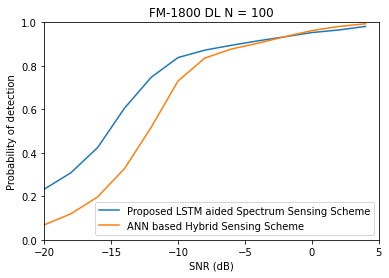

In [26]:
k = 30

dict1 = final_dataset(FM[200000:], range(-20, -4, 2), 125 * k, 100)
dict2 = final_dataset(FM[200000:], range(-4, 6, 2), 200 * (100 - k), 100)

X_FM = {**dict1, **dict2}

X_FM_lb = dataset_look_back(X_FM, range(-20, 6, 2), 1)
print(X_FM_lb[-20].shape)

X = X_FM_lb[-20]
y = []
X_test = X_test_FM_lb[-20]

for snr in range(-18, 6, 2):
  X = np.concatenate((X, X_FM_lb[snr]), axis=0)
  X_test = np.concatenate((X_test, X_test_FM_lb[snr]), axis=0)
  
y = np.ones((X.shape[0], 1))
y_test = np.ones((X_test.shape[0], 1))
  
X = np.concatenate((X, X_noise_lb), axis=0)
X = X_FM_lb[-20]
y = []
X_test = X_test_FM_lb[-20]

for snr in range(-18, 6, 2):
  X = np.concatenate((X, X_FM_lb[snr]), axis=0)
  X_test = np.concatenate((X_test, X_test_FM_lb[snr]), axis=0)
  
y = np.ones((X.shape[0], 1))
y_test = np.ones((X_test.shape[0], 1))
  
X = np.concatenate((X, X_noise_lb), axis=0)

y = np.concatenate((y, np.zeros((X_noise_lb.shape[0], 1))))

print(X.shape)
print(y.shape)

model = Sequential()
model.add(LSTM(16, input_shape=(1, 200)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y,
          batch_size=32, epochs=15)

scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

pd2_FM = {}

for snr in range(-20, 5, 2):
  X_snr = X_test_FM_lb[snr]
  y = np.ones((X_test_FM_lb[snr].shape[0], 1))
  y_snr = np.ones((X_test_FM_lb[snr].shape[0], 1))
  scores = model.evaluate(X_snr, y_snr)
  print("At SNR = " + str(snr) + "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  pd2_FM[snr] = scores[1]
  
plt.plot(*zip(*sorted(pd2_FM.items())), label='Proposed LSTM aided Spectrum Sensing Scheme')
plt.plot(*zip(*sorted(pd1_FM.items())), label='ANN based Hybrid Sensing Scheme')
plt.legend()
plt.xlabel('SNR (dB)')
plt.ylabel('Probability of detection')
plt.xlim([-20, 5])
plt.ylim([0, 1])

plt.title('FM-1800 DL N = 100')

y_noise = np.zeros((X_noise_test_lb.shape[0], 1))
scores = model.evaluate(X_noise_test_lb, y_noise)
print("Noise performance = " + "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("pfa = " + str(1 - scores[1]))

plt.savefig('FM N=100.jpg', format='jpg', dpi=1000)

In [27]:
#print("Accuracy: ", np.sum(prediction > 0.5, axis=0))